In [1]:
import pandas as pd
import os
from tqdm import tqdm
import argparse
import yaml
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import bokeh

from utils import *
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
# General info dataframe
filepath_measurements_info = "/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/sd_tweezers_info_1.csv"
results_dir = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/3_plots/'

df_general_info = pd.read_csv(filepath_measurements_info, delimiter=';', encoding='utf-8')
df_general_info.head()

save_to_server = True

## Show an example of beads and tracks, visualize the end point of the tweezer tip

[ 98 378]
Shape of the images array: (300, 695, 665, 3)


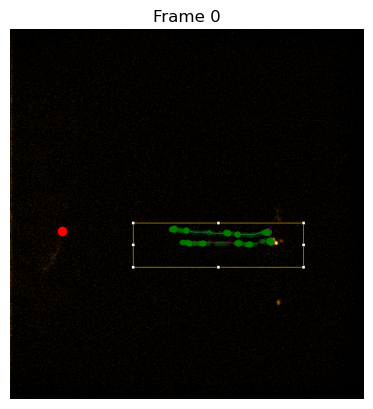

In [3]:
filepath = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/1_measurements/20240523/20240523_s01p01t01/TrackMate capture of 20240523_s01p01t01_1_5sON_15sOFF_1000mV-1.tif'

tip = df_general_info.loc[df_general_info['trackmate_file'].str.contains('20240523_s01p01t01_1_5sON_15sOFF'), ['tip_x', 'tip_y']].values[0]

df = pd.read_hdf('/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/measurements_extended_info/20240523_s01p01t01_1_5sON_15sOFF_spots_extended.h5')
tracks_x = df['POSITION_X'].values
tracks_y = df['POSITION_Y'].values

print(tip)
# Load the time series TIFF file
images = tifffile.imread(filepath)

# Check the shape of the images array (T, Z, Y, X) or (T, Y, X) depending on the data
print("Shape of the images array:", images.shape)
pix_size = 0.54 # (um)
# Plot the first frame of the time series
plt.figure()
plt.imshow(images[0], cmap='gray')
plt.plot(tip[0], tip[1], 'ro')
plt.plot(tracks_x/pix_size, tracks_y/pix_size, 'g.', alpha =0.2)
plt.title('Frame 0')
plt.axis('off')
plt.show()

In [4]:
df_general_info = df_general_info.sort_values(by='trackmate_file')
df_general_info.head(5)

,trackmate_file,MTs,first_pulse (frame),last_pulse_start (frame),t_on (frame),t_off (frame),tip_x,tip_y,calibration (mV),bead_type,time_interval (s),comments
0,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,131,251,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
1,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,169,249,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
2,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,13,653,10,30,53,314,1000,2.8 um myc dyna passivated PEG,0.5,NaN
3,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,11,611,10,30,57,360,1000,2.8 um myc dyna passivated PEG,0.5,"one bead stuck during pulses 7,8,9,10"
4,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,11,531,10,30,82,254,1000,2.8 um myc dyna passivated PEG,0.5,NaN


In [5]:
folder = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/measurements_extended_info/'

df_results = pd.DataFrame(columns = ['exp_date', 'sample', 'position', 'embryo', 'rep', 'track_id', 'pulse_n', 'rising_dif', 'relaxing_dif', 'rising_dif_norm', 'relative_dif', 'MT_status'])

for idx in range(len(df_general_info)):
    filepath = df_general_info['trackmate_file'].values[idx]
    filename = os.path.basename(filepath).split('.')[0]
    file_h5 = f'{filename}_extended.h5'
    # load data to dataframe
    df = pd.read_hdf(folder + file_h5, key='df')
    df = df.sort_values(by='POSITION_T')

    # if 'exclude' in str(df_general_info['comments'].values[idx]):
    #     continue

    for track_id in df['TRACK_ID'].unique():
        track = df[df['TRACK_ID']==track_id]
        for pulse_n in track['PULSE_NUMBER'].unique():
            if pulse_n == 1:
                continue

            pulse = track[track['PULSE_NUMBER']==pulse_n]
            if not np.all(pulse['CORRECTED DISPLACEMENT [um]'].notna()):
                continue
            displacement = pulse['CORRECTED DISPLACEMENT [um]'].values

            rising_phase = pulse.loc[pulse['MAGNET_STATUS']==1, 'CORRECTED DISPLACEMENT [um]'].values
            if len(rising_phase) < 2:
                continue
            rising_dif_norm = (rising_phase[-1]-rising_phase[0])/np.average(pulse.loc[pulse['MAGNET_STATUS']==1, 'FORCE [pN]'].values)
            rising_dif_norm_inverse = 1/rising_dif_norm

            rising_phase = pulse.loc[pulse['MAGNET_STATUS']==1, 'CORRECTED DISPLACEMENT [um]'].values
            rising_dif = rising_phase[-1]-rising_phase[0]
            rising_phase

            relaxing_phase = pulse.loc[pulse['MAGNET_STATUS']==0, 'CORRECTED DISPLACEMENT [um]'].values
            if len(relaxing_phase) < 2:
                continue
            relaxing_dif = relaxing_phase[-1]-relaxing_phase[0]
            if (relaxing_dif < 0) and (rising_dif > 0) and (- relaxing_dif/rising_dif <= 1):
                new_line = {
                    'exp_date': [filename.split('_')[0]], 
                    'sample': [filename.split('_')[1][0:3]], 
                    'position': [filename.split('_')[1][3:6]], 
                    'embryo': [filename.split('_')[0]+filename.split('_')[1][0:6]],
                    'rep': [filename.split('_')[1][6:9]], 
                    'track_id': track_id,
                    'pulse_n': pulse_n,
                    'avg_force': np.average(pulse.loc[pulse['MAGNET_STATUS']==1, 'FORCE [pN]'].values),
                    'rising_dif': [rising_dif], 
                    'relaxing_dif': [relaxing_dif], 
                    'rising_dif_norm': [rising_dif_norm], 
                    'rising_dif_norm_inverse': [rising_dif_norm_inverse],
                    'relative_dif': [-relaxing_dif/rising_dif], 
                    'MT_status': [pulse['MT_STATUS'].values[0]]
                }
                df_results = pd.concat([df_results, pd.DataFrame(new_line)])
if save_to_server:
    if not os.path.exists(f'{results_dir}results/'):
        os.makedirs(f'{results_dir}results/')
    df_results.to_csv(f'{results_dir}results/results_independent_analysis.csv', index=False)
df_results.head(10)

,exp_date,sample,position,embryo,rep,track_id,pulse_n,rising_dif,relaxing_dif,rising_dif_norm,relative_dif,MT_status,avg_force,rising_dif_norm_inverse
0,20240523,s01,p01,20240523s01p01,t02,7,2,18.373588,-0.960466,0.215221,0.052274,n,85.370844,4.646389
0,20240523,s01,p01,20240523s01p01,t02,7,3,10.724688,-0.794941,0.104329,0.074123,n,102.796749,9.585057
0,20240523,s02,p01,20240523s02p01,t01,0,2,2.746239,-0.797658,0.082738,0.290455,y,33.191957,12.086332
0,20240523,s02,p01,20240523s02p01,t01,0,3,2.101621,-0.587285,0.062717,0.279444,y,33.509729,15.944707
0,20240523,s02,p01,20240523s02p01,t01,0,4,1.751934,-1.045616,0.051769,0.596835,y,33.841663,19.316741
0,20240523,s02,p01,20240523s02p01,t01,0,5,3.537769,-1.335269,0.102817,0.377433,y,34.408397,9.726016
0,20240523,s02,p01,20240523s02p01,t01,0,6,2.219984,-1.001666,0.063756,0.451204,y,34.820155,15.684867
0,20240523,s02,p01,20240523s02p01,t01,0,7,5.629420,-0.704700,0.158186,0.125182,y,35.587355,6.321674
0,20240523,s02,p01,20240523s02p01,t01,0,8,4.188529,-1.387693,0.114702,0.331308,y,36.516598,8.718239
0,20240523,s02,p01,20240523s02p01,t01,1,2,1.708031,-1.394235,0.055674,0.816282,y,30.679311,17.961799


   MT_status       mean        std     median         q1         q3
16         y   1.879259   0.863368   1.670548   1.335788   2.335431
15         y   3.572780   1.980470   2.554904   2.061264   5.329551
14         y   1.020914   0.406302   0.990272   0.743734   1.202268
13         y   1.965568   0.462139   1.885260   1.687994   2.336678
12         y   1.982398   0.850484   1.778273   1.429002   2.330365
11         y   2.144185   0.621382   2.056077   1.607850   2.579254
10         y   2.503555   0.972473   2.302816   1.764779   2.765982
9          n  22.709060  11.216384  24.198041  19.166846  28.062119
0          n  14.549138   5.408589  14.549138  12.636913  16.461363
1          n  14.789580  10.235688  11.200254   5.848324  22.104200
7          n  12.288233  13.178801   5.829173   3.643190  19.290051
6          n  14.790985   7.882228  12.424672  11.103628  15.446188
5          n   8.794858   7.643511   6.129361   2.865015  12.516582
4          n   5.887756   3.331659   4.377679   

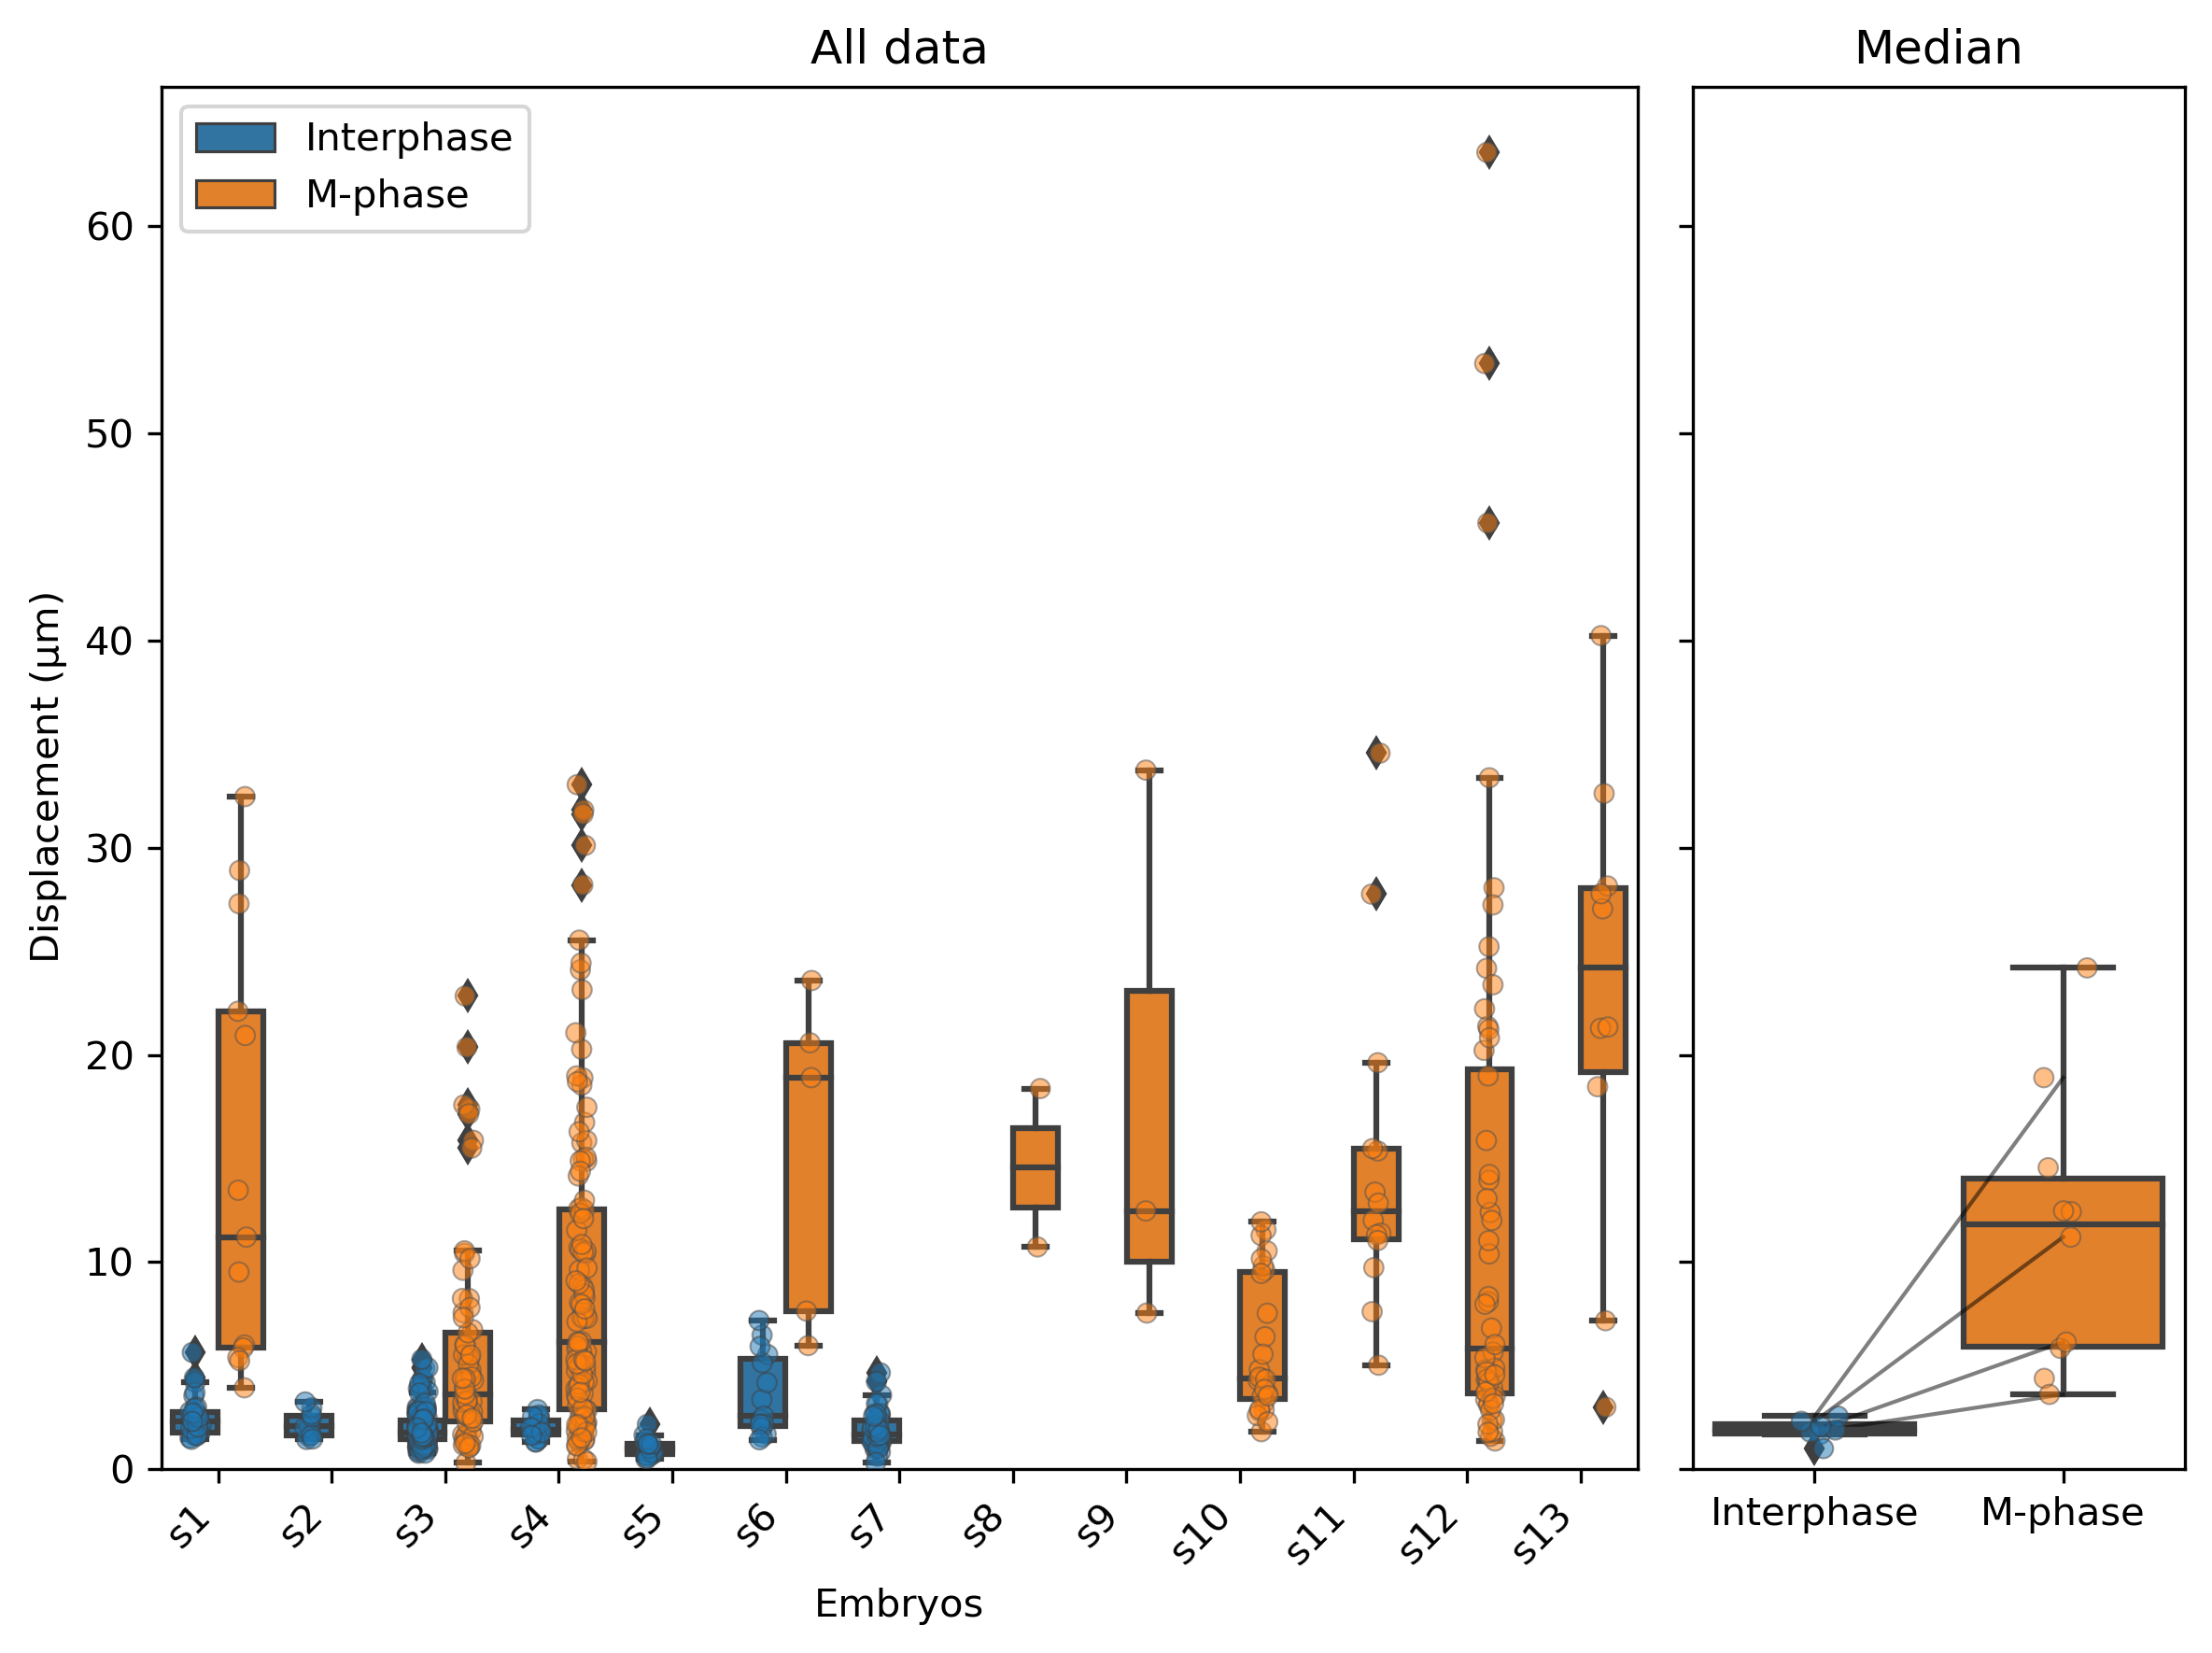

   MT_status      mean       std    median        q1        q3
16         y -0.817154  0.418414 -0.866899 -1.136430 -0.509261
15         y -0.673213  0.396742 -0.629348 -0.766825 -0.525417
14         y -0.525238  0.223811 -0.465402 -0.687062 -0.344824
13         y -0.792156  0.268162 -0.713391 -1.015514 -0.635040
12         y -0.742517  0.350498 -0.700660 -0.945788 -0.499581
11         y -1.060377  0.155580 -1.081073 -1.176257 -0.972745
10         y -1.026818  0.271982 -1.042259 -1.197439 -0.797037
9          n -1.762770  1.112048 -1.738070 -2.586872 -0.901687
0          n -0.877704  0.117043 -0.877704 -0.919085 -0.836322
1          n -2.206360  1.018360 -1.655226 -2.520871 -1.368221
7          n -1.185530  0.578242 -1.130084 -1.566406 -0.771290
6          n -1.244700  0.434204 -1.232897 -1.533058 -0.977665
5          n -0.992568  0.593665 -0.935184 -1.409448 -0.522754
4          n -1.055238  0.369949 -1.033990 -1.363555 -0.797964
3          n -0.913016  0.516902 -0.873600 -1.256836 -0

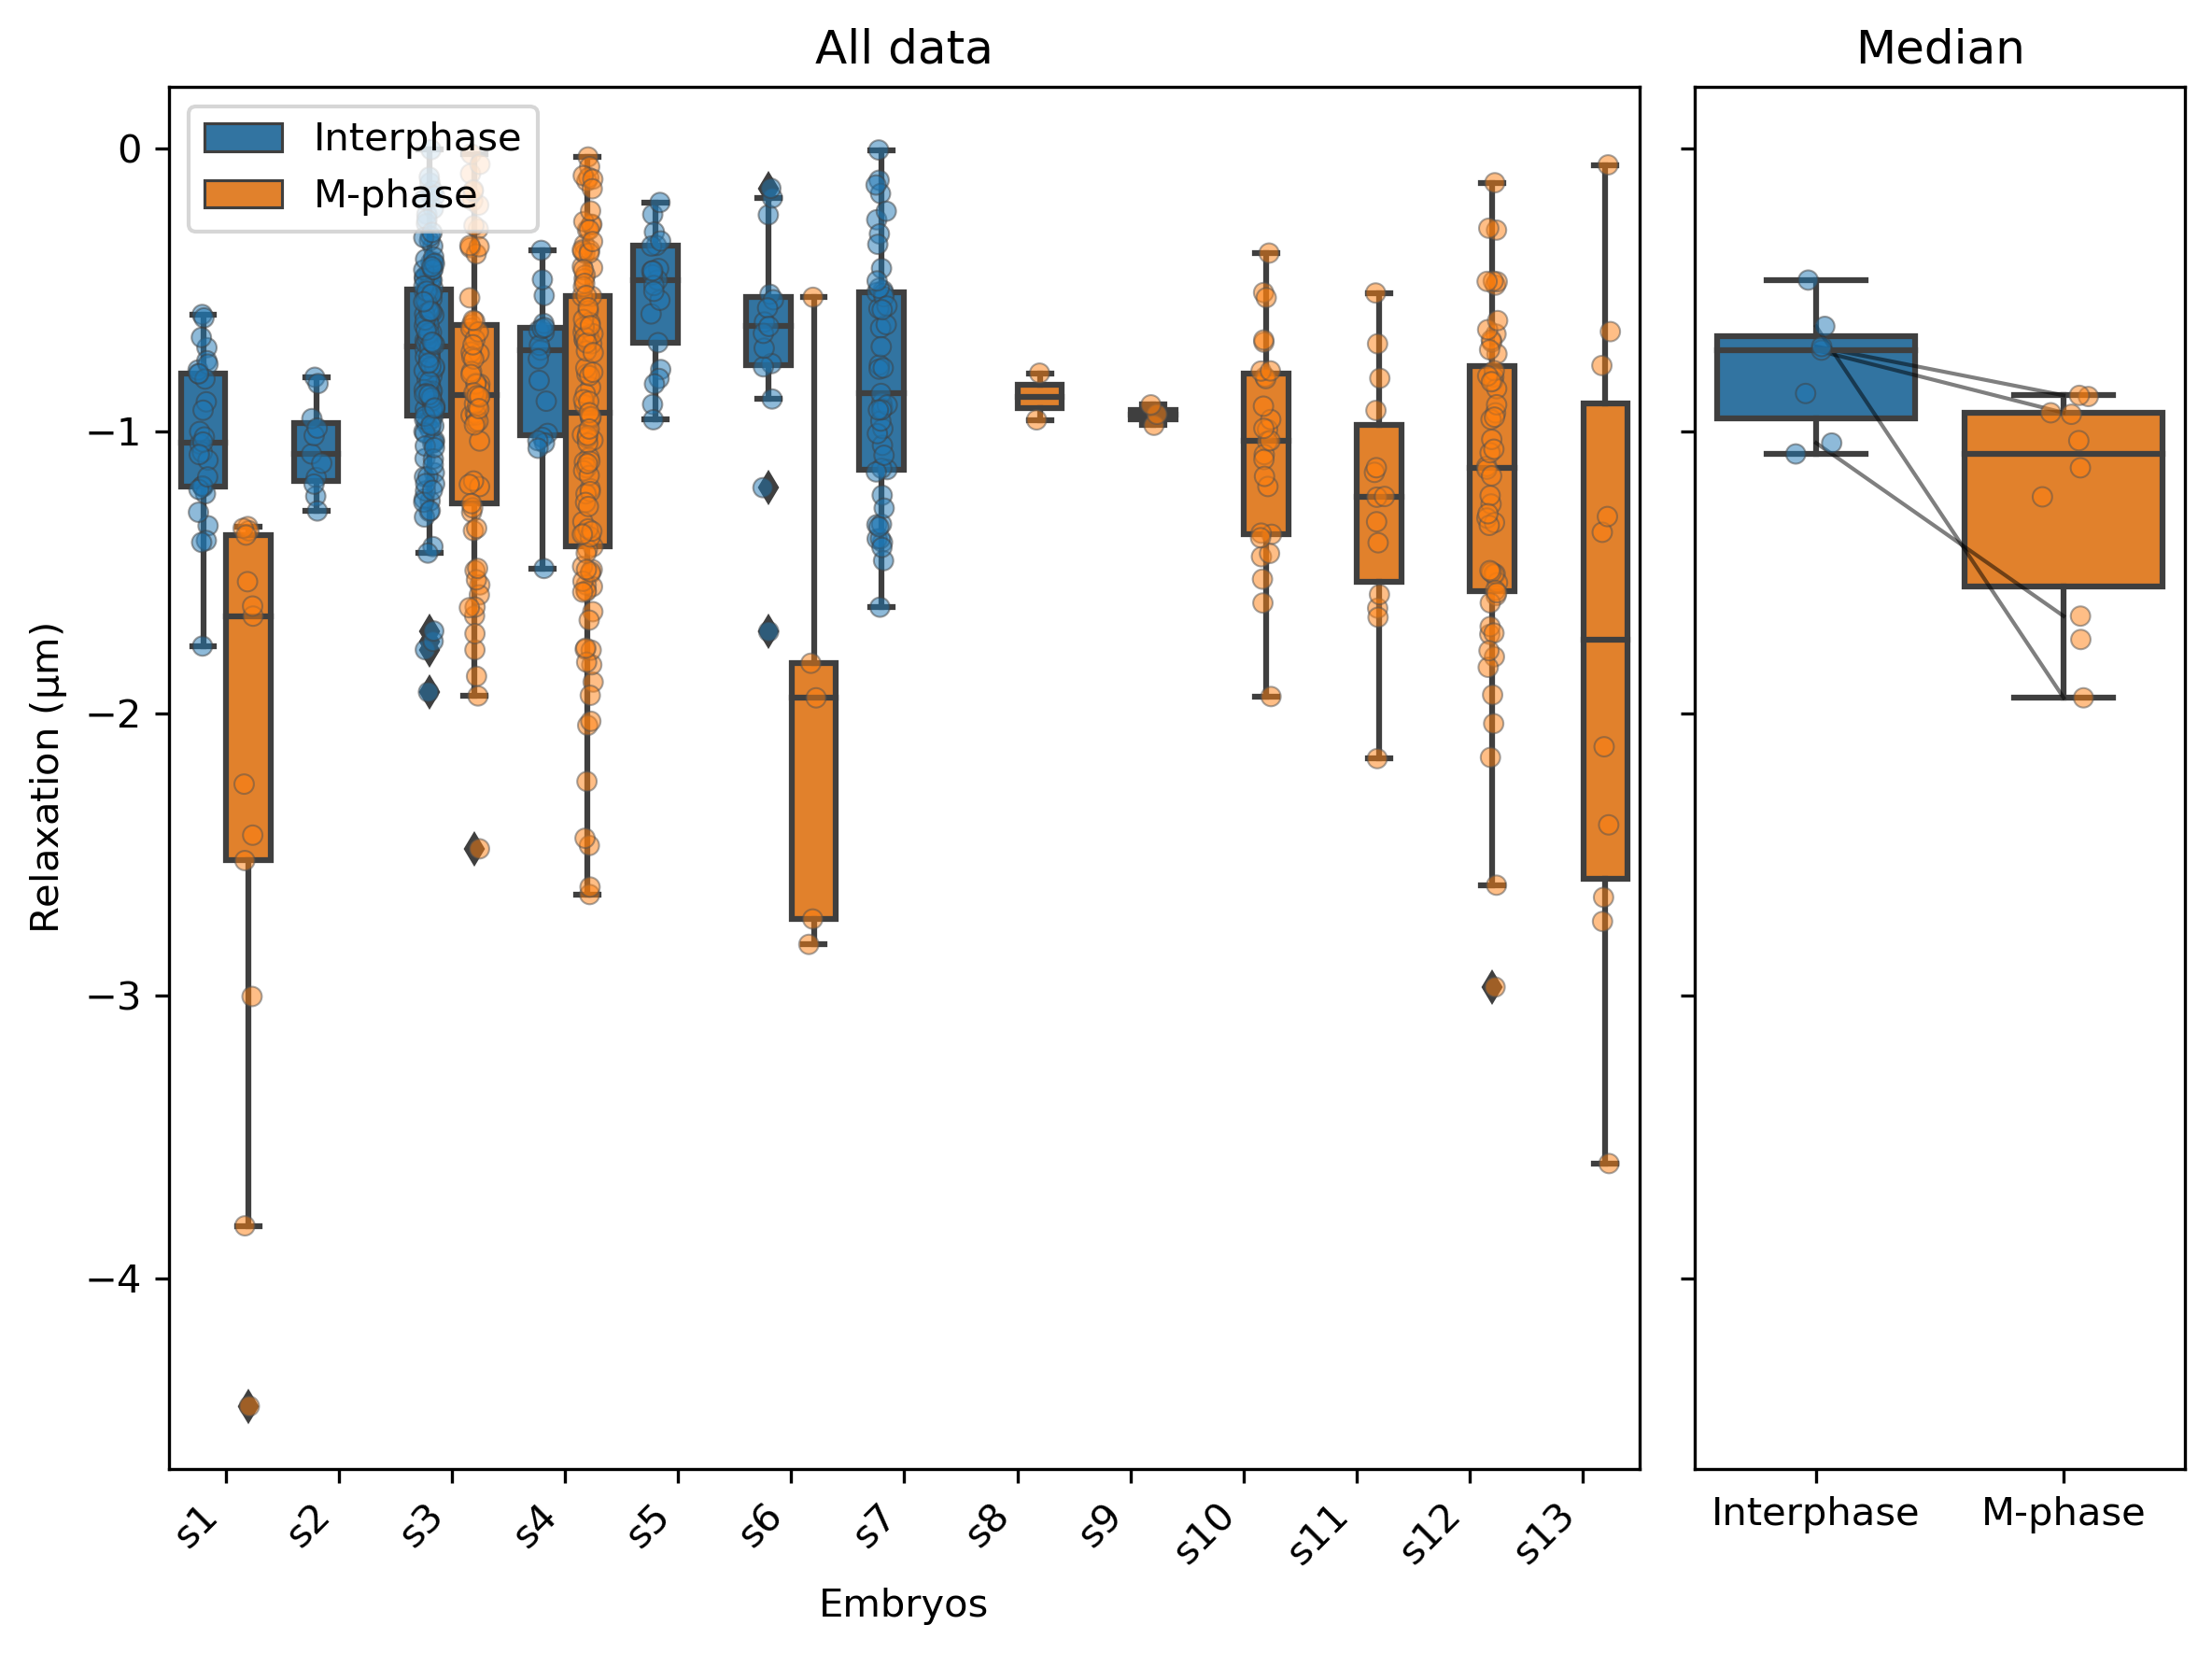

   MT_status      mean       std    median        q1        q3
16         y  0.041437  0.018722  0.037602  0.028670  0.048739
15         y  0.134933  0.079027  0.105523  0.067120  0.207155
14         y  0.039614  0.015192  0.037624  0.029591  0.046517
13         y  0.036176  0.008371  0.035800  0.029170  0.042174
12         y  0.049266  0.021280  0.045190  0.034951  0.058056
11         y  0.048708  0.012986  0.048228  0.037266  0.057707
10         y  0.076190  0.027728  0.067653  0.055817  0.087265
9          n  0.339164  0.195323  0.316393  0.237722  0.428640
0          n  0.159775  0.078412  0.159775  0.132052  0.187498
1          n  0.167627  0.127034  0.142150  0.074768  0.203209
7          n  0.259312  0.231411  0.147963  0.075356  0.425449
6          n  0.302742  0.182948  0.239704  0.211144  0.273651
5          n  0.158859  0.135062  0.119950  0.054889  0.242328
4          n  0.111968  0.066338  0.082059  0.064012  0.168388
3          n  0.095442  0.088391  0.067330  0.035024  0

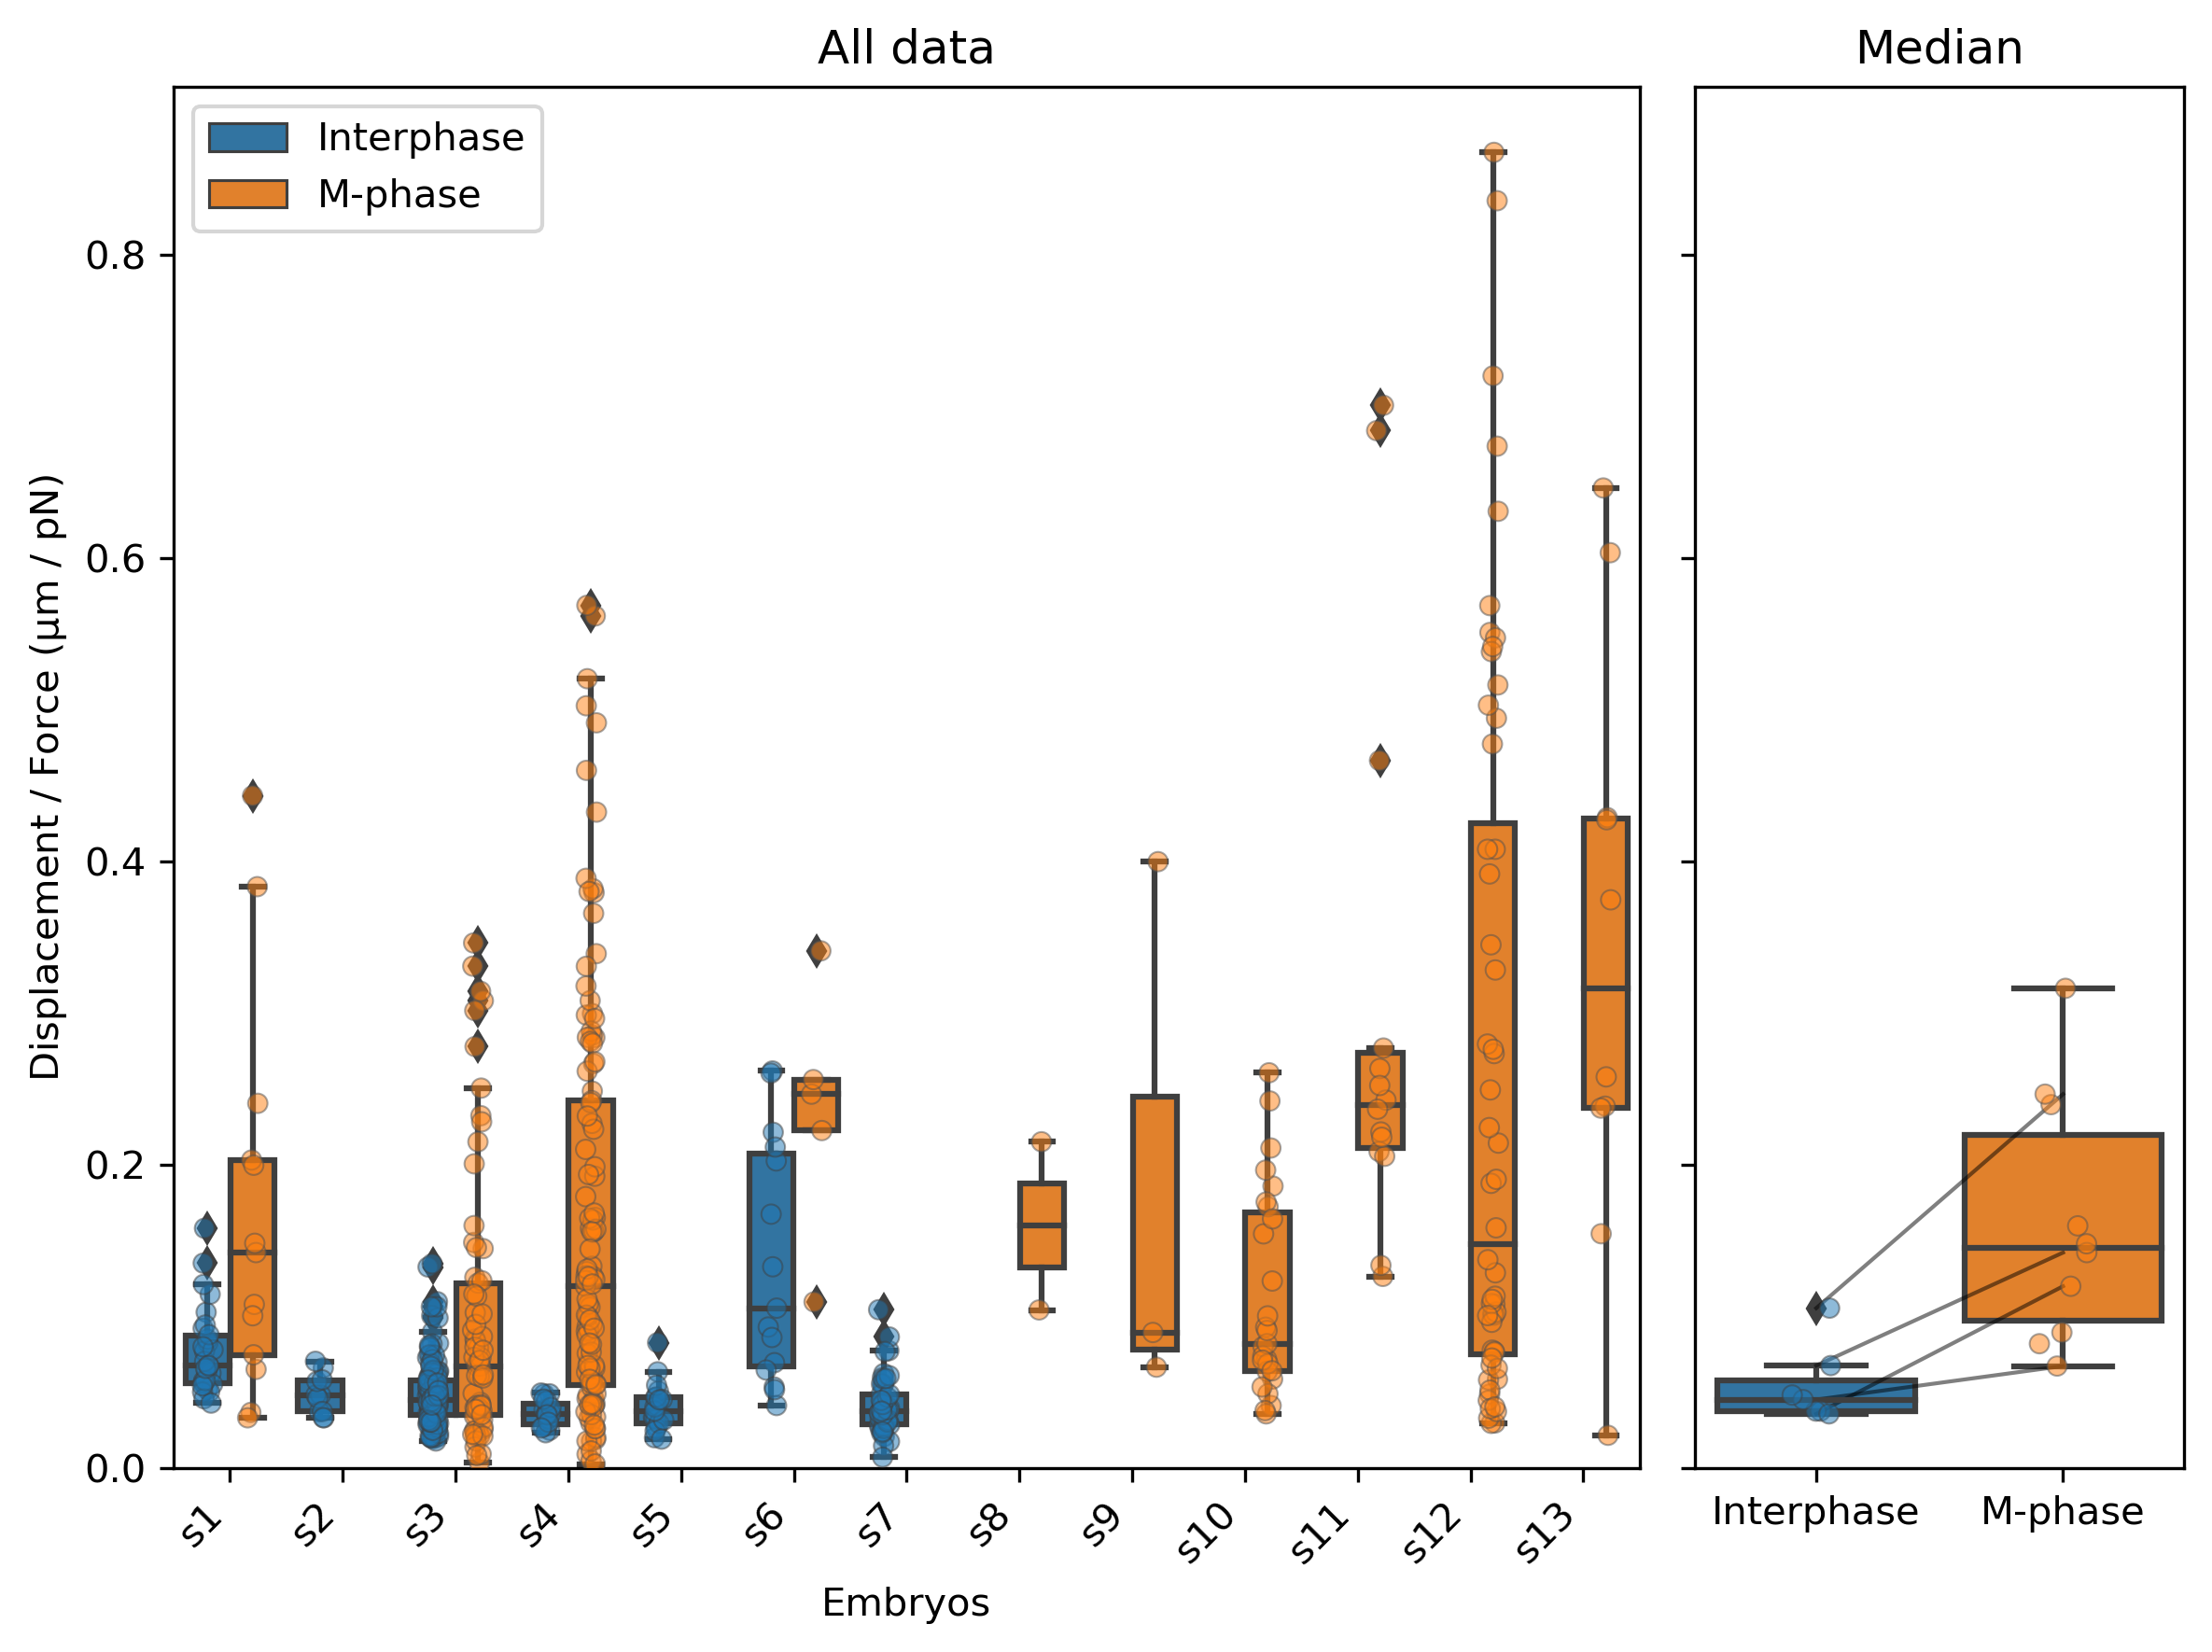

   MT_status       mean        std     median         q1         q3
16         y  30.177023  19.523587  26.594316  20.517488  34.879217
15         y  10.614851   6.509511   9.476636   4.829653  14.918026
14         y  28.701843  10.504655  26.578487  21.497312  33.793921
13         y  29.122050   6.914900  27.933299  23.774955  34.333890
12         y  23.897909   9.848947  22.128968  17.224733  28.612180
11         y  21.898310   5.769777  20.734990  17.330612  26.834522
10         y  14.568567   4.384776  14.781344  11.461800  17.916168
9          n   7.542669  13.642694   3.271995   2.332968   4.206620
0          n   7.115723   3.492166   7.115723   5.881056   8.350390
1          n  10.614509   8.923200   7.034805   4.921043  13.374784
7          n   9.523683   8.874931   6.792782   2.361352  13.276400
6          n   4.205344   1.871017   4.172463   3.655991   4.737822
5          n  18.727366  39.699877   8.336788   4.126640  18.218641
4          n  12.355372   6.872046  12.186340   

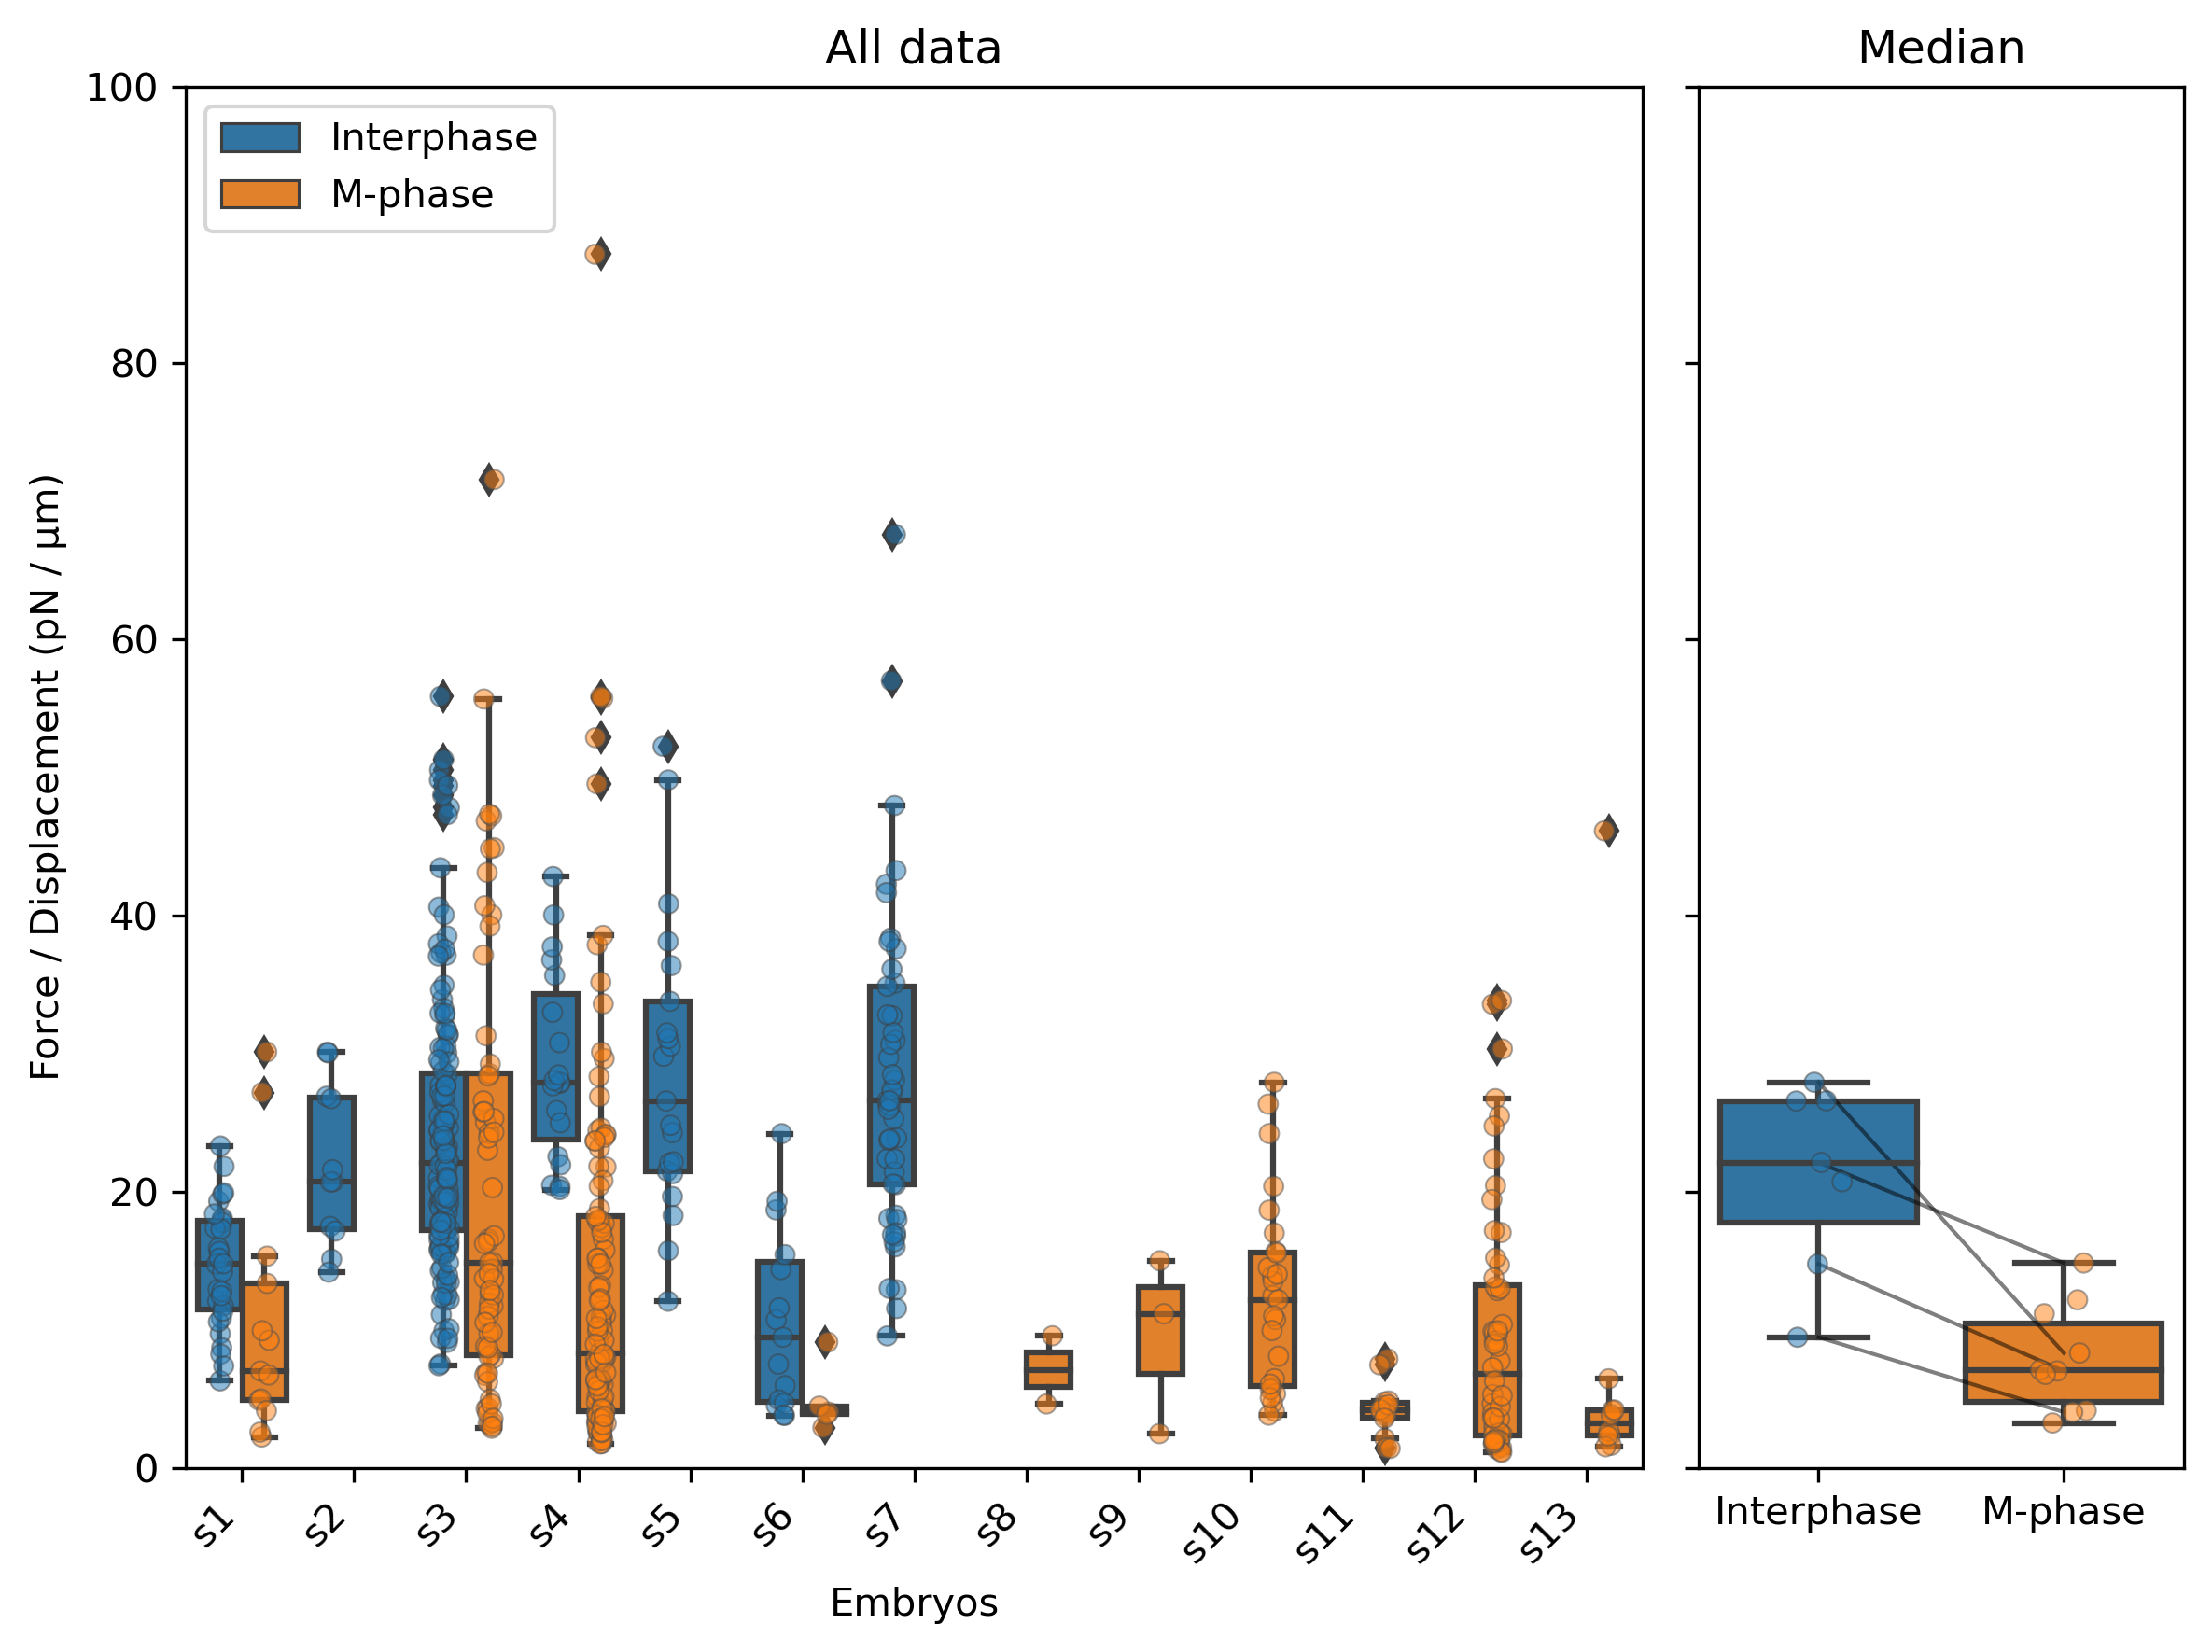

   MT_status      mean       std    median        q1        q3
16         y  0.472886  0.231096  0.450296  0.316131  0.658423
15         y  0.262387  0.206860  0.290399  0.113410  0.320065
14         y  0.569217  0.239551  0.573618  0.359627  0.760680
13         y  0.418623  0.148437  0.413304  0.318623  0.508839
12         y  0.412486  0.208229  0.388506  0.252664  0.544023
11         y  0.524639  0.144244  0.477883  0.405652  0.618563
10         y  0.455436  0.172245  0.416186  0.347021  0.578562
9          n  0.119857  0.117568  0.078259  0.042955  0.170868
0          n  0.063198  0.015449  0.063198  0.057736  0.068660
1          n  0.225393  0.149744  0.225905  0.089049  0.342625
7          n  0.216253  0.194570  0.139509  0.068027  0.334060
6          n  0.112709  0.078849  0.090152  0.082601  0.143737
5          n  0.225531  0.235913  0.139118  0.073484  0.251642
4          n  0.219443  0.105935  0.225593  0.125169  0.280033
3          n  0.288363  0.233702  0.230988  0.094119  0

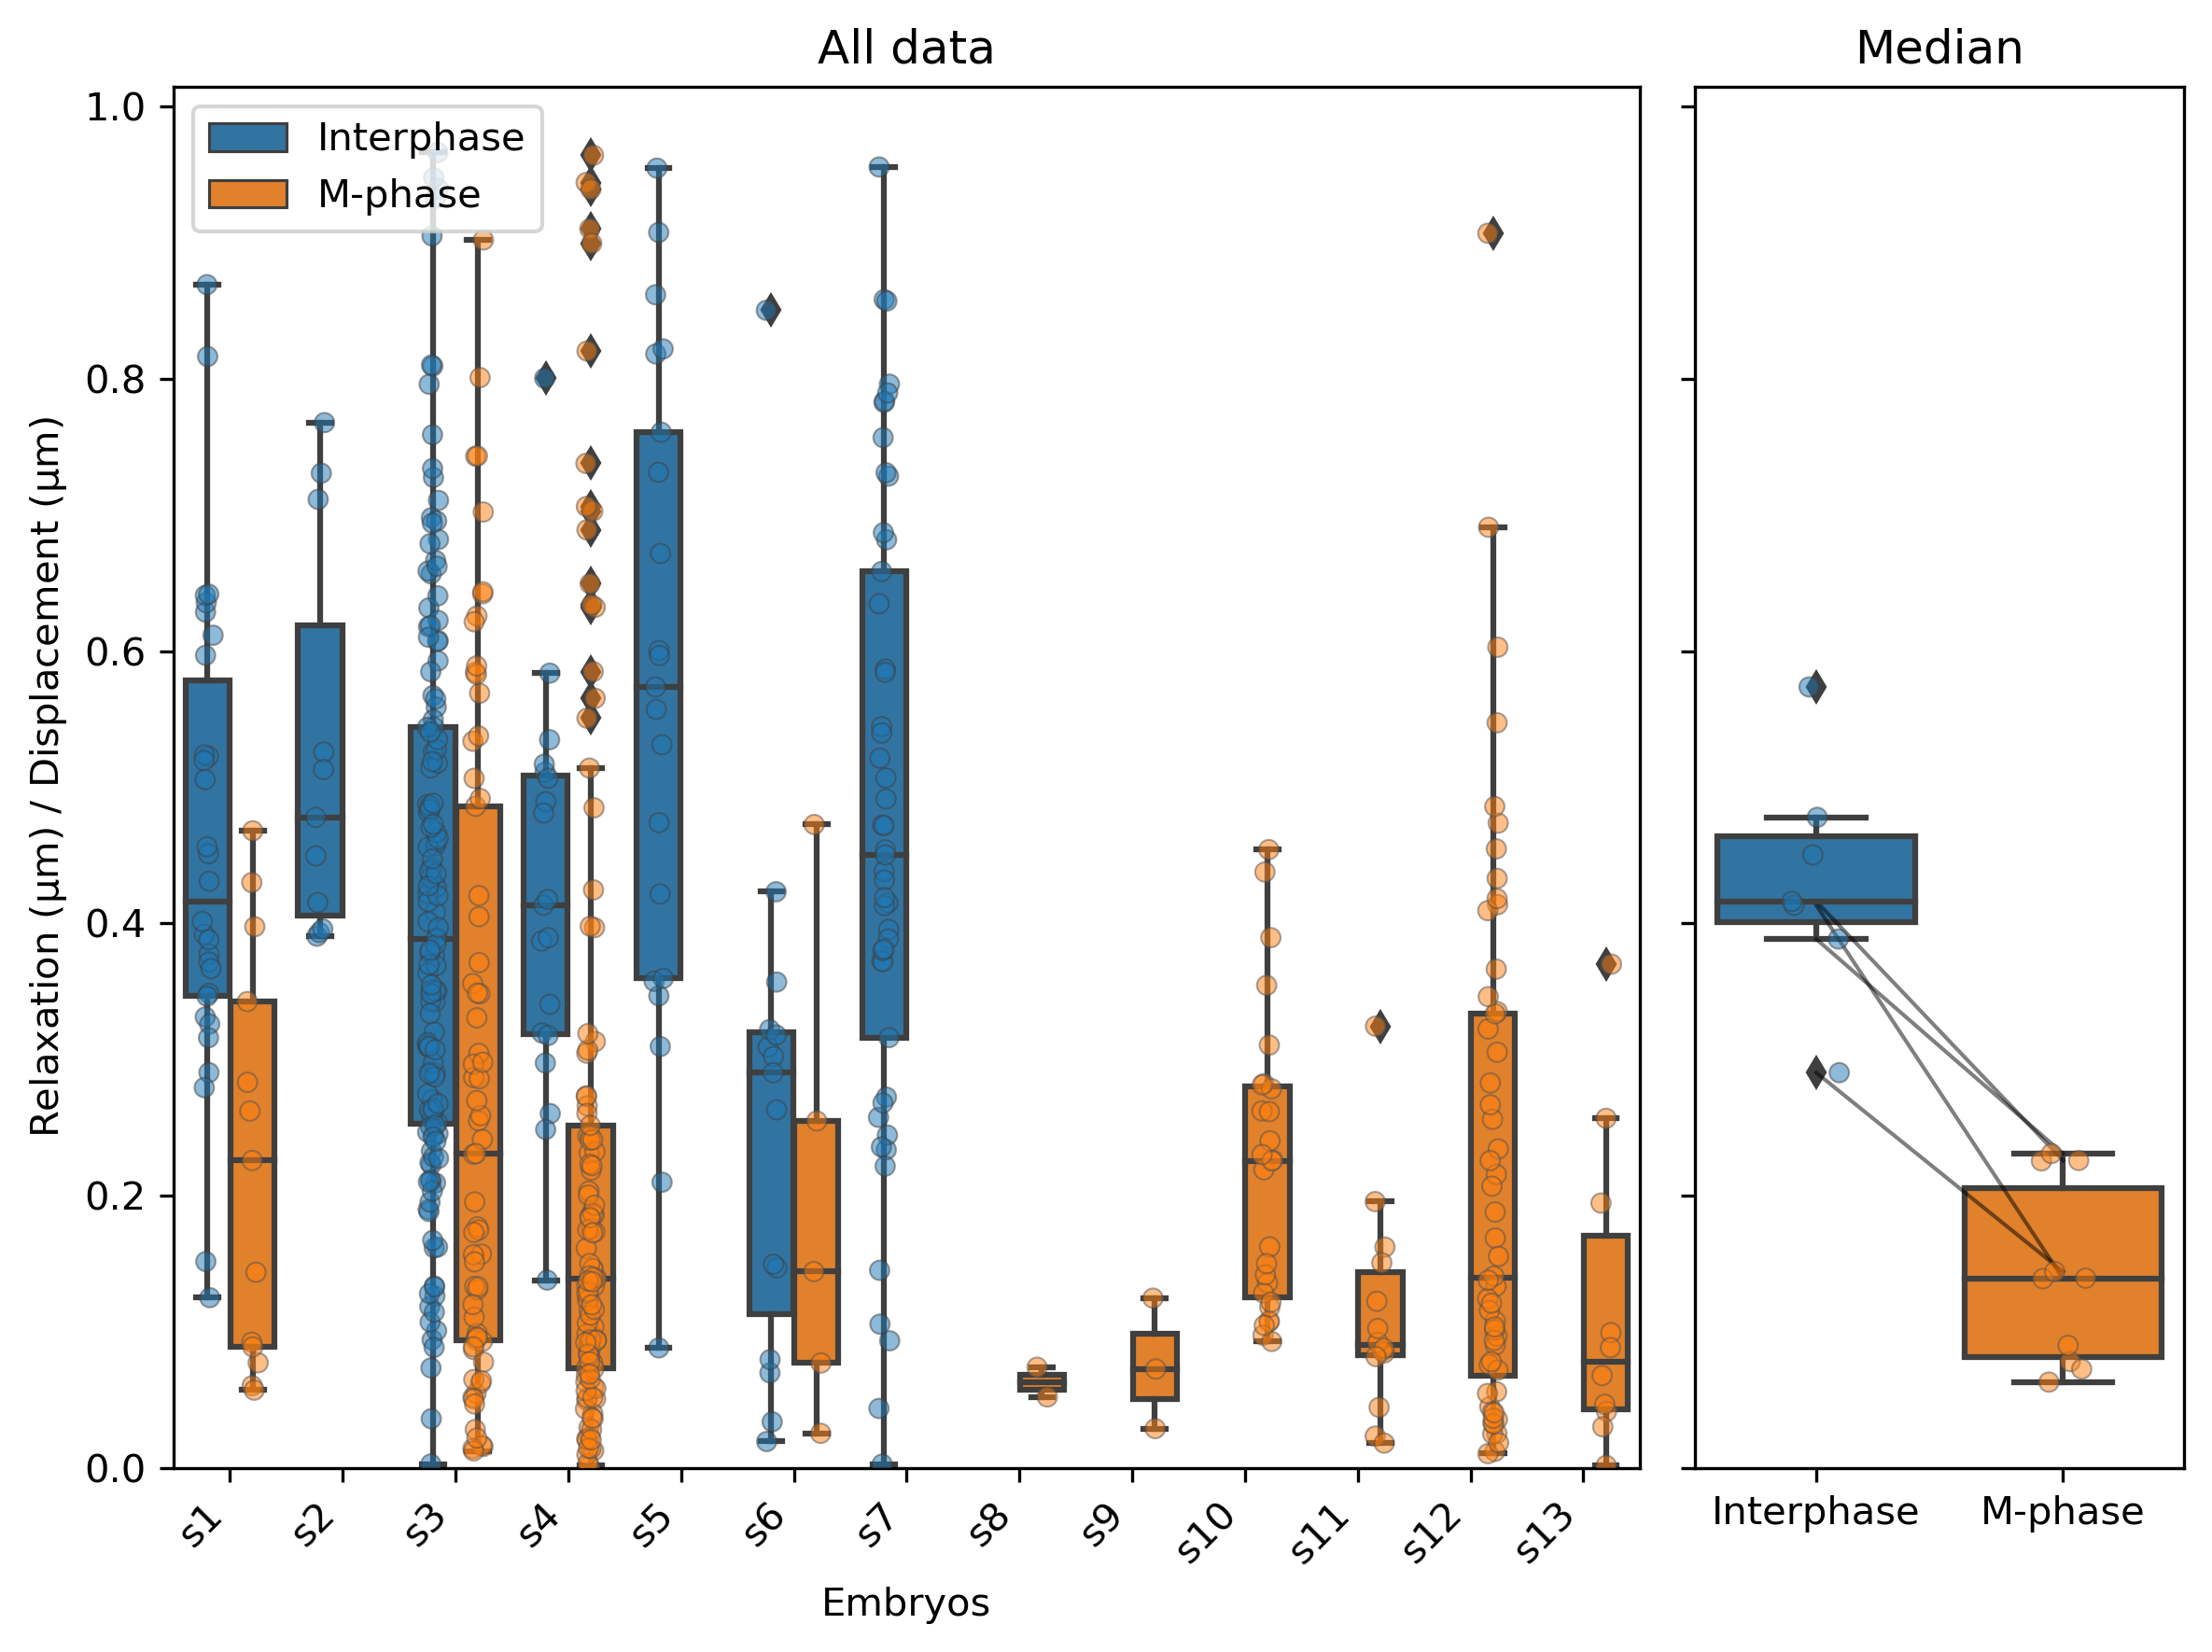

In [6]:
df_results = df_results.sort_values(by=['MT_status', 'embryo'], ascending=[False, True])
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)

df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])

params = ['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif']
labels = ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement (pN / $\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$) / Displacement ($\mathrm{\\mu m}$)']

df = df_results
for (param, label) in zip(params, labels):
    
    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 6), dpi=300, sharey=True, gridspec_kw={'width_ratios': [3, 1]})

    # First subplot: Combined boxplot and stripplot
    sns.boxplot(ax=axes[0], x='embryo', y=param, hue='Phase', data=df)
    sns.stripplot(ax=axes[0], x='embryo', y=param, hue='Phase', dodge=True, data=df, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    axes[0].set_xticks(ticks=range(len(df['embryo'].unique())))
    axes[0].set_xticklabels(labels=['s' + str(i+1) for i in range(len(df['embryo'].unique()))], rotation=45, ha='right')
    axes[0].set_ylabel(label)
    axes[0].set_xlabel('Embryos')

    # Add custom legend to the first plot
    axes[0].legend(loc='upper left')
    axes[0].set_title('All data')

    # Second subplot: Summary statistics
    sns.boxplot(ax=axes[1], x='MT_status', y='median', data=stats)
    sns.stripplot(ax=axes[1], x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')
    axes[1].set_xticklabels(labels=['Interphase', 'M-phase'])
    axes[1].set_title(f'Median')

     # Calculate statistics
    stats_ = stats.drop(columns=['embryo'])
    print(stats_)
    stats_of_stats = stats_[['MT_status', 'median']].groupby(['MT_status']).agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats_of_stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats_of_stats['parameter'] = param
    stats_of_stats = stats_of_stats.reset_index()
    stats_of_stats = stats_of_stats.sort_values(by='MT_status', ascending=False)
    print(stats_of_stats)
    
    df_median_stats = pd.concat([df_median_stats, stats_of_stats])

    for embryo in stats['embryo'].unique():
        if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
            axes[1].plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    # Show the plots
    if param != 'relaxing_dif':
        plt.ylim(bottom=0)
    if param == 'rising_dif_norm_inverse':
        plt.ylim(top=100)
    plt.tight_layout()

    if save_to_server:
        plt.savefig(f'{results_dir}results/result_{param}.svg', format='svg')
    plt.show()

In [7]:
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity median'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'median'].values) # in Pa.s median(eff_viscosity) = dt/(6*pi*r*median(rising_dif_norm))
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity mean'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'mean'].values) # in Pa.s mean(eff_viscosity) = dt/(6*pi*r*mean(rising_dif_norm))
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity q1'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'q1'].values) 
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity q3'] = np.divide(5/(6*np.pi*1.4),df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'q3'].values) 
df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'viscosity std'] = np.multiply(df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'std'].values, np.divide(5/(6*np.pi*1.4),np.square(df_median_stats.loc[df_median_stats['parameter']=='rising_dif_norm', 'median'].values))) # in Pa.s std(eff_viscosity) = std(rising_dif_norm)*dt/(6*pi*r*median(rising_dif_norm)**2)

if save_to_server:
    df_median_stats.to_csv(f'{results_dir}results/results_simple_analysis_stats_of_median.csv')

for (i, embryo) in enumerate(df['embryo'].unique()):
    print(embryo, f's{i}')
    print('Interphase')
    print('N = ', len(df[(df['embryo']==embryo)&(df['Phase']=='Interphase')]))
    print('M-phase')
    print('N = ', len(df[(df['embryo']==embryo)&(df['Phase']=='M-phase')]))

df = df.sort_values(by='embryo',ascending=False)
for embryo in df['embryo'].unique():
    print(embryo)
    print(df.loc[df['embryo']==embryo, 'MT_status'].unique())

20240523s02p01 s0
Interphase
N =  30
M-phase
N =  13
20240614s02p02 s1
Interphase
N =  11
M-phase
N =  0
20240621s01p01 s2
Interphase
N =  143
M-phase
N =  69
20240621s02p02 s3
Interphase
N =  19
M-phase
N =  117
20240705s01p01 s4
Interphase
N =  21
M-phase
N =  0
20240705s02p01 s5
Interphase
N =  15
M-phase
N =  5
20240711s01p01 s6
Interphase
N =  49
M-phase
N =  0
20240523s01p01 s7
Interphase
N =  0
M-phase
N =  2
20240618s01p02 s8
Interphase
N =  0
M-phase
N =  3
20240621s02p01 s9
Interphase
N =  0
M-phase
N =  27
20240703s02p01 s10
Interphase
N =  0
M-phase
N =  14
20240703s03p01 s11
Interphase
N =  0
M-phase
N =  56
20240705s03p01 s12
Interphase
N =  0
M-phase
N =  10
20240711s01p01
['y']
20240705s03p01
['n']
20240705s02p01
['y' 'n']
20240705s01p01
['y']
20240703s03p01
['n']
20240703s02p01
['n']
20240621s02p02
['y' 'n']
20240621s02p01
['n']
20240621s01p01
['n' 'y']
20240618s01p02
['n']
20240614s02p02
['y']
20240523s02p01
['y' 'n']
20240523s01p01
['n']


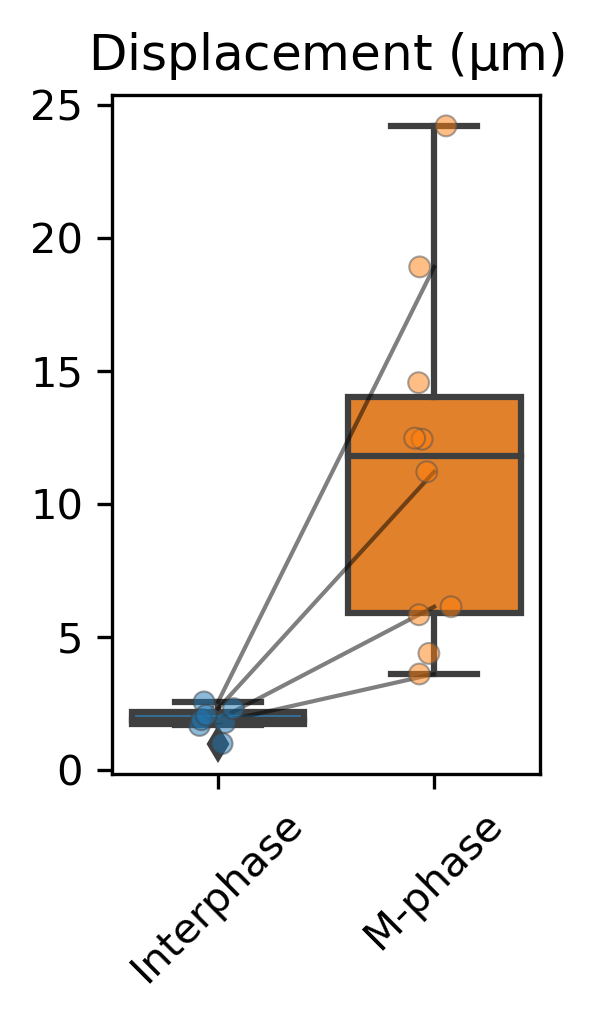

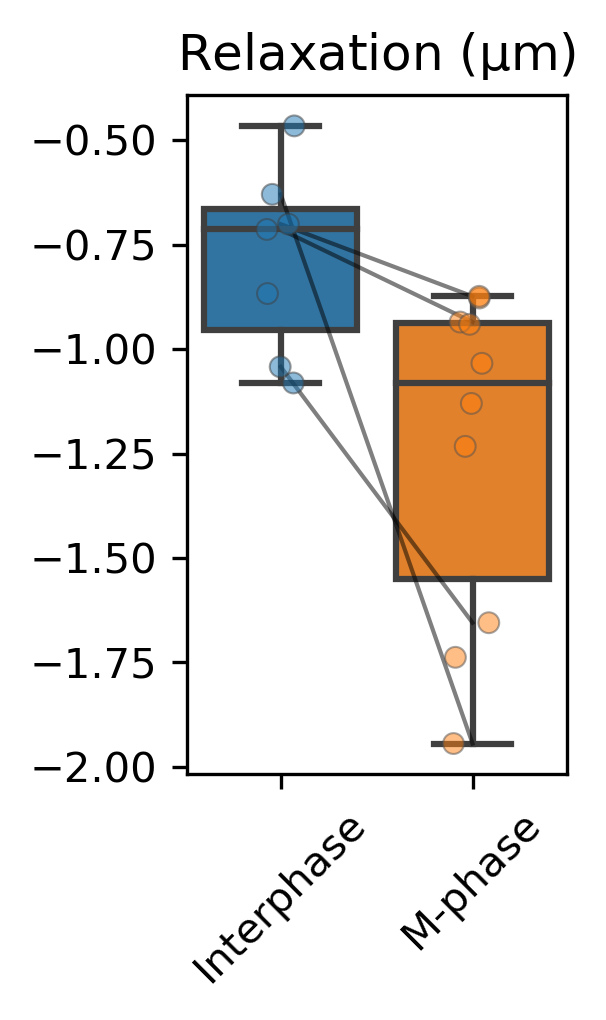

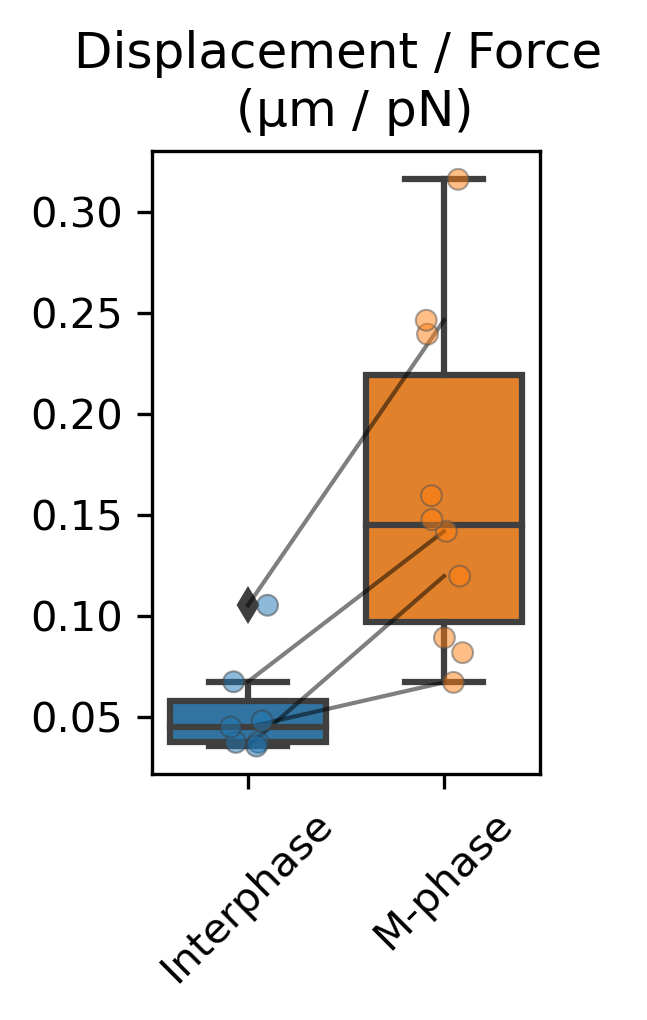

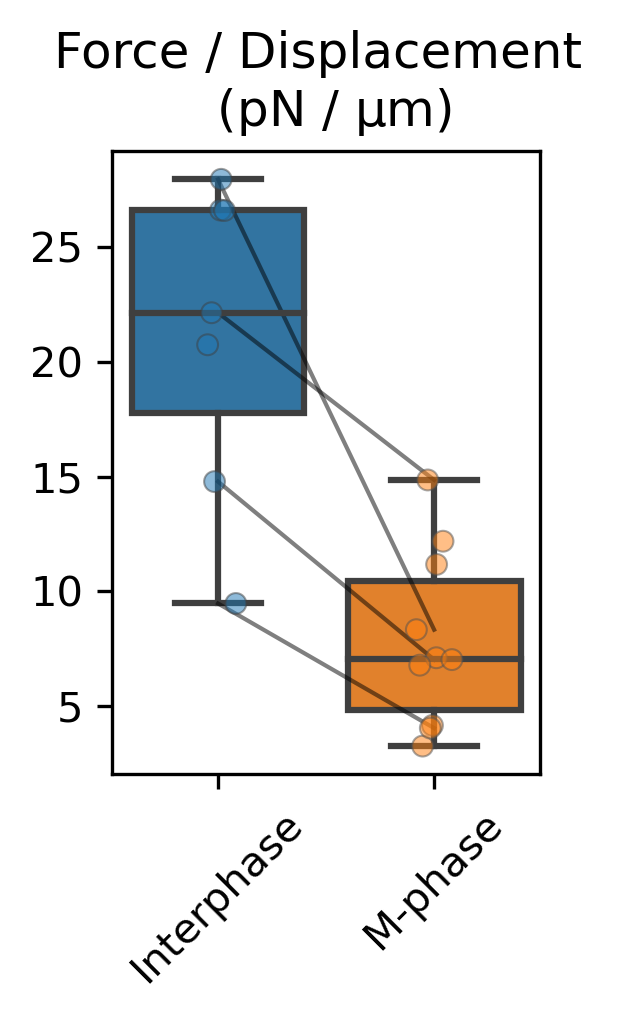

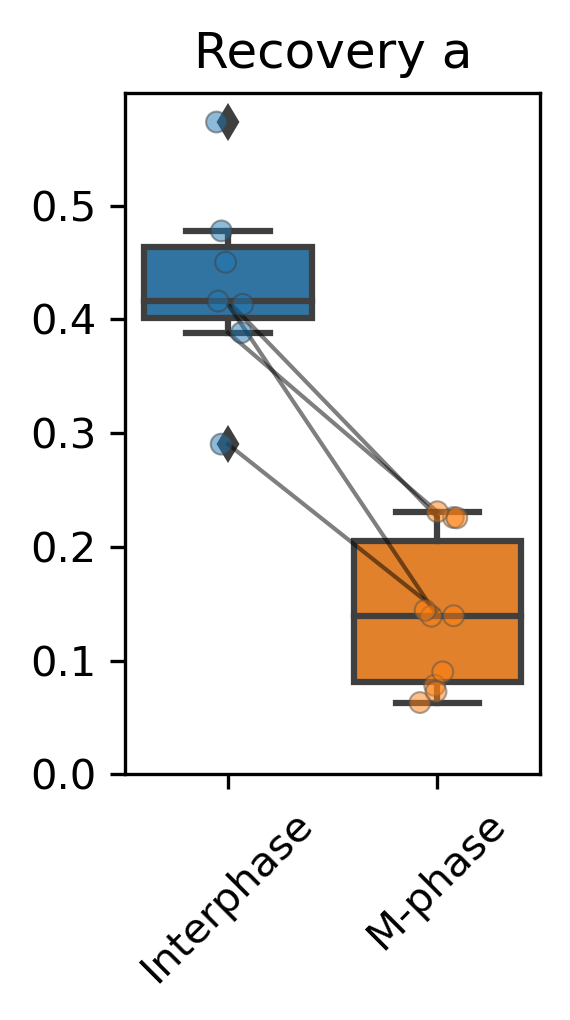

In [8]:
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)


df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])

for (param, label) in zip(['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif'], ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force \n ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement \n (pN / $\mathrm{\\mu m}$)', 'Recovery a']):

    df = df_results

    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)
    

    # Create subplots
    fig = plt.figure(figsize=(2, 3.5), dpi=300)

    # Second subplot: Summary statistics
    sns.boxplot(x='MT_status', y='median', data=stats)
    sns.stripplot(x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.5, linewidth=0.5, legend=False)
    plt.title(f'{label}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks = ['y', 'n'], labels=['Interphase', 'M-phase'], rotation=45)

    for embryo in stats['embryo'].unique():
        if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
            plt.plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    if param == 'rising_dif_norm':
        pass
    elif param == 'relative_dif':
        plt.ylim(bottom=0)
    
    
    plt.tight_layout()
    if save_to_server:
        plt.savefig(f'{results_dir}results/result_{param}_modelindependent_median.svg', format='svg')
    plt.show()

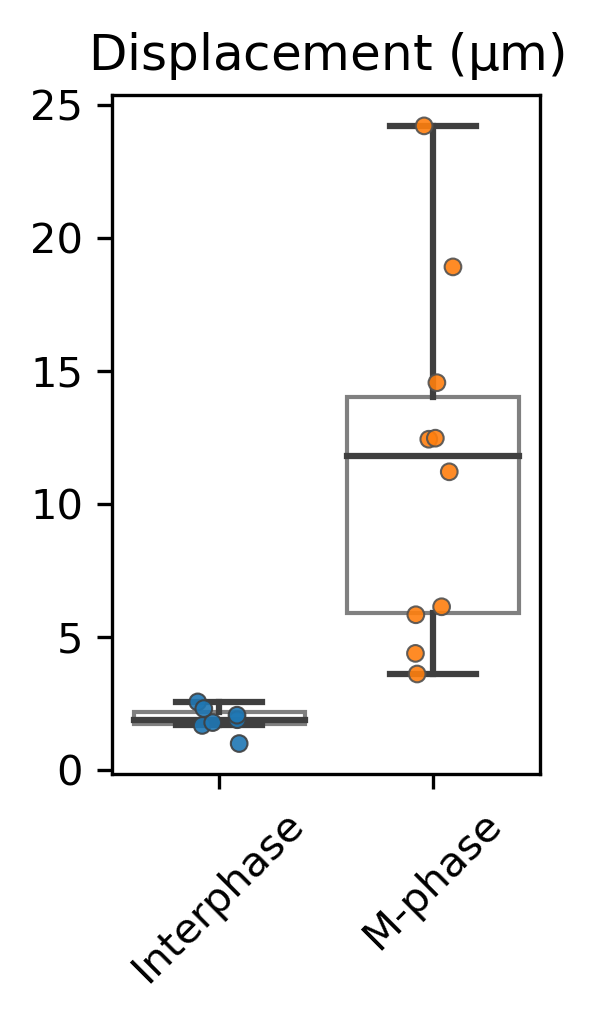

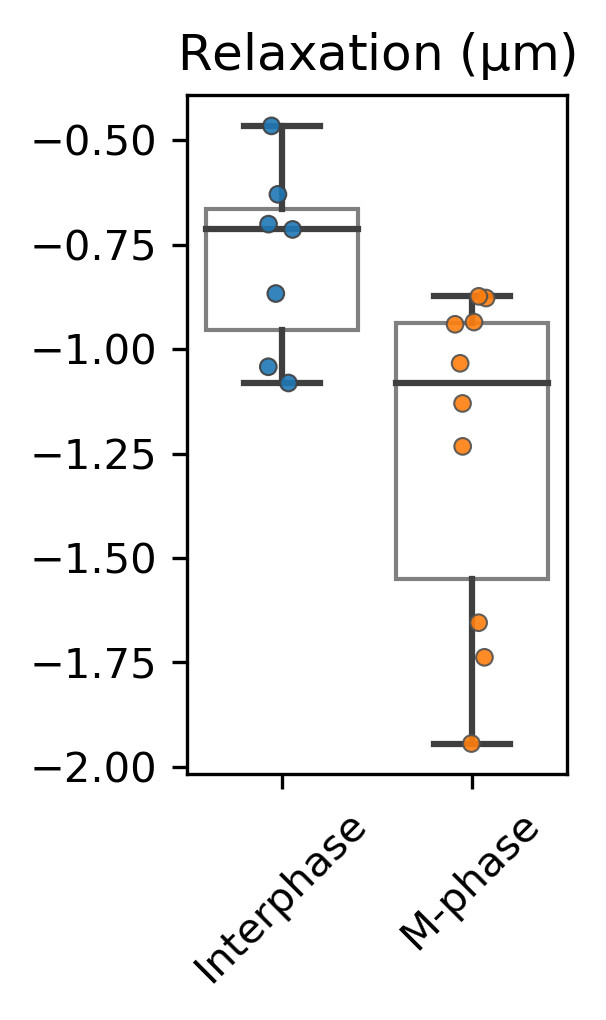

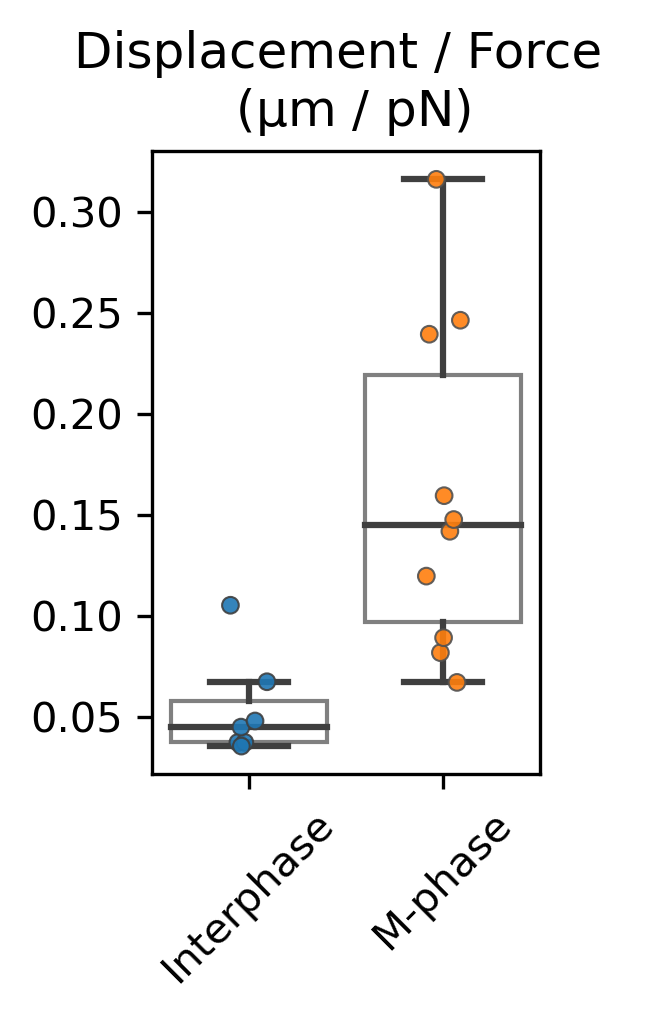

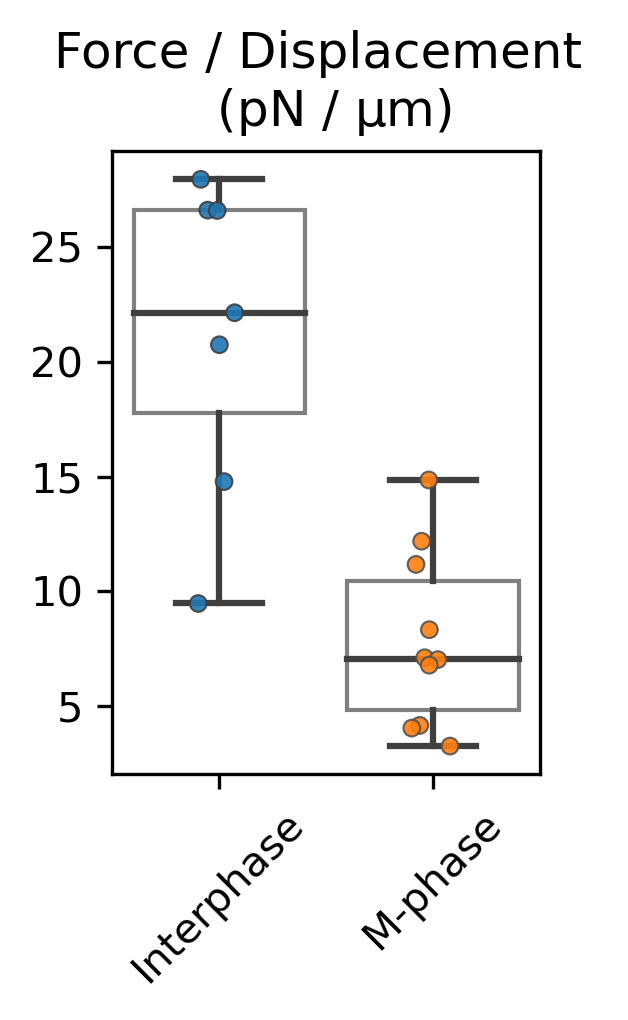

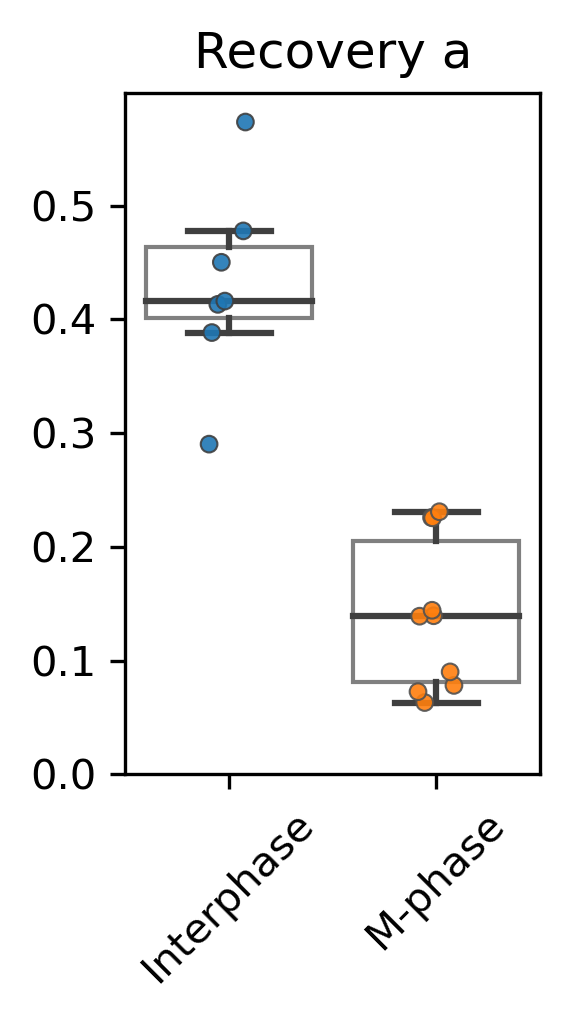

In [9]:
# Define the mapping
mapping = {'y': 'Interphase', 'n': 'M-phase'}

# Create a new column based on the mapping
df_results['Phase'] = df_results['MT_status'].map(mapping)


df_median_stats = pd.DataFrame(columns=['mean', 'std', 'median', 'q1', 'q3', 'parameter'])

for (param, label) in zip(['rising_dif', 'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse', 'relative_dif'], ['Displacement ($\mathrm{\\mu m}$)', 'Relaxation ($\mathrm{\\mu m}$)', 'Displacement / Force \n ($\mathrm{\\mu m}$ / pN)', 'Force / Displacement \n (pN / $\mathrm{\\mu m}$)', 'Recovery a']):

    df = df_results

    # Calculate statistics
    stats = df.groupby(['MT_status', 'embryo'])[param].agg(['mean', 'std', 'median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
    stats.columns = ['mean', 'std', 'median', 'q1', 'q3']
    stats = stats.reset_index()
    stats = stats.sort_values(by='MT_status', ascending=False)
    

    # Create subplots
    fig = plt.figure(figsize=(2, 3.5), dpi=300)

    # Second subplot: Summary statistics
    boxprops = dict(linestyle='-', linewidth=1, color='gray', fill=False)
    sns.boxplot(x='MT_status', y='median', data=stats, boxprops=boxprops, fliersize=0)
    sns.stripplot(x='MT_status', y='median', hue='MT_status', data=stats, jitter=True, alpha=0.9, linewidth=0.5, legend=False, size=4)
    plt.title(f'{label}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks = ['y', 'n'], labels=['Interphase', 'M-phase'], rotation=45)

    # for embryo in stats['embryo'].unique():
    #     if len(stats.loc[stats['embryo']==embryo, 'median'].values) == 2:
    #         plt.plot(['y', 'n'], stats.loc[stats['embryo']==embryo, 'median'].values, 'k-', alpha = 0.5, linewidth=1)

    if param == 'rising_dif_norm':
        pass
    elif param == 'relative_dif':
        plt.ylim(bottom=0)
    
    
    plt.tight_layout()
    if save_to_server:
        plt.savefig(f'{results_dir}results/result_{param}_modelindependent_median_v2.svg', format='svg')
    plt.show()